In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

The data can be found here: https://www.kaggle.com/itssuru/loan-data

In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Checking for missing values

In [5]:
df.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [6]:
df.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

It appears there are no missing values

replacing the periods in column names with underscores for ease of use purposes.

In [7]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [8]:
df.not_fully_paid.value_counts()

0    8045
1    1533
Name: not_fully_paid, dtype: int64

# Splitting the data

The original dataframe, or a subset of it, dividing it into equal groups, will be used for exploratory data analysis.  For removing extreme outliers only what will be used as the training set in model development will be used.

In [9]:
original = df.copy()
df, df_test = train_test_split(df, random_state=675, test_size=0.2)

In [10]:
paid=original[original.not_fully_paid==0]
not_paid =original[original.not_fully_paid==1]
paid_subsample = paid.sample(n=1000)
not_paid_subsample = not_paid.sample(n=1000)
df_subsample = pd.concat([paid_subsample,not_paid_subsample])

# Exploring the features


## Credit policy

1 if the customer meets the credit underwriting policy of lending club, 0 if they do not.

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

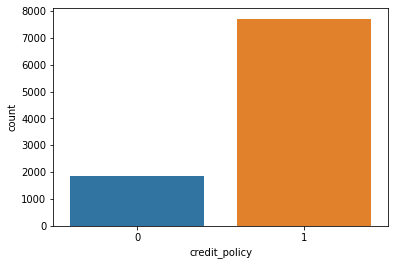

In [11]:
sns.countplot(x = 'credit_policy', data = original)

More customers meet the credit policy than not.

Now compairing credit policy counts with fully paid counts...

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

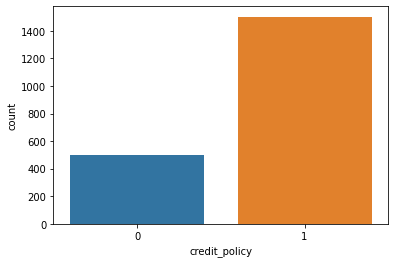

In [12]:
# this doesnt work, need to use percentages as there are more that meet the credit policy
sns.countplot(x = 'not_fully_paid', hue = 'credit_policy', data = df_subsample)
# or can I use sns.countplot(x = 'credit_policy', data = df_subsample)